In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

In [2]:
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as o
import geotorch
import torchvision.transforms as t

from src.distributions import *
from src.loggers import TensorBoardLogger, WandbLogger
from src.solvers import OTSolver
from src.plotters import SimplePlotter, plot_samples
from src.utils import *
from src.models.resnet import resnet14_d

from torchvision.datasets import MNIST
from torchsummary import summary
from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tb_logger = TensorBoardLogger()
wandb_logger = WandbLogger(project="optimal-transport", entity="_devourer_")

In [3]:
data_dim = (1, 32, 32)
p, q = np.prod(data_dim, dtype=int), 2
n_neurons = 128

critic = nn.Sequential(
    nn.Linear(q, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, n_neurons), nn.LeakyReLU(), nn.Dropout(.1),
    nn.Linear(n_neurons, 1), nn.Tanh()
)

mover = resnet14_d(data_dim, q)

In [4]:
class InnerGW_opt:
    def __init__(self, p, q, l=.05,
                 n_iter=10,
                 optimizer=o.Adam,
                 optimizer_params=dict(lr=5e-5),
                 logger=None, device=DEVICE):
        self.P = nn.Sequential(
            nn.Flatten(),
            nn.Linear(p, q, bias=False)
        ).to(device)
        geotorch.sphere(self.P[1], "weight")
        self.P_opt = optimizer(self.P.parameters(), **optimizer_params)

        self.l = l
        self.n_iter = n_iter

        self.logger = logger
        self.step = 0
        self.device = device

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        for _ in range(self.n_iter):
            self.P_opt.zero_grad()
            Px = self.P(x)
            cost = self.l * (torch.norm(Px - y.detach(), 2, dim=1) ** 2)
            cost.mean().backward()
            self.P_opt.step()
        Px = self.P(x)
        if self.logger:
            with torch.no_grad():
                target_P = get_explicit_P(x, y).to(self.device)
                P_mse = F.mse_loss(self.P.weight, target_P)
                self.logger.log("P MSE", P_mse.item(), 1 + self.step // 15)
            self.step += 1
        return self.l * torch.norm(Px - y, 2, dim=1) ** 2


class InnerGW_const:
    def __init__(self, P, l=.05):
        self.P = P
        self.l = l

    def __call__(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        Px = x.flatten(1) @ self.P
        return self.l * torch.norm(Px - y, 2, dim=1) ** 2


In [5]:
def run_experiment(source, target, cost, n_iter,
                   plotter, logger=None, **kwargs):
    if logger:
        logger.start()
    try:
        solver = OTSolver(deepcopy(critic), deepcopy(mover), cost=cost,
                          plotter=plotter, logger=logger, device=DEVICE,
                          **kwargs)
        solver.fit(source, target, n_iter)
    except KeyboardInterrupt:
        pass
    finally:
        if logger:
            logger.finish()
    return solver

In [6]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = t.functional.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [7]:
def load_mnist(root, transform=None):
    dataset = MNIST(root, transform=transform)
    images, targets = [], []
    for image, target in tqdm(dataset):
        images.append(image)
        targets.append(target)
    return torch.stack(images), torch.tensor(targets)

In [8]:
features, classes = load_mnist("../../data/",
                               transform=t.Compose([t.Pad(2), t.ToTensor()]))
source = TensorDatasetDistribution(features, classes)

n_components = 10

locs_2d = uniform_circle(n_components)
scales_2d = .15 * torch.ones(n_components, q)
target = gaussian_mixture(locs_2d, scales_2d)


100%|██████████| 60000/60000 [00:12<00:00, 4643.67it/s]


In [9]:
U, s, V = torch.pca_lowrank(features.flatten(1), 2)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: _devourer_ (use `wandb login --relogin` to force relogin)


<Figure size 432x288 with 0 Axes>

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

cost,▇▇█▃▂▁▂▂▂▁█▂▅▁▃▁▂▂▂▁▂▂▃▂▂▂▂▂▂▁▁▃▁▃▃▂▂▂▂▂
loss,▆▁▆▆█▃▆▇▄▅▅▅▄▆▅▆▅▅▆▆▅▆▆▆▆▆▅▆▆▆▅▅▆▆▆▆▅▅▅▆
cost,0.00112
loss,-0.00087


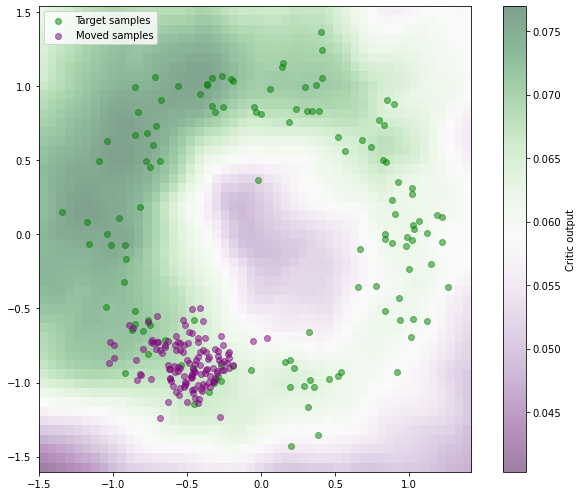

In [11]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=128,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=p,
        target_dim=q,
        pdf_params=dict(
            source_lims=None,
            target_lims=None,
            n_points=500
        )
                    # show_progress=False
                    ),
    logger=wandb_logger,
    n_inner_iter=10,
    plot_interval=20,
    log_plot_interval=100,
)

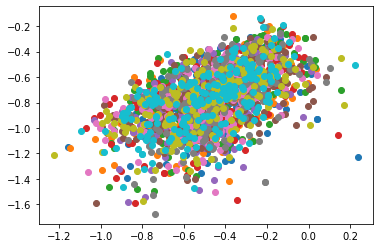

In [13]:
for cls in range(10):
    samples = source.sample_from_class((200,), 0)
    with torch.no_grad():
        moved_samples = solver.mover(samples.to(DEVICE))
    plot_samples(moved_samples.cpu())
plt.show()


In [14]:
n_components = 10

locs_2d = uniform_circle(n_components)
scales_2d = .3 * torch.ones(n_components, q)
target = gaussian_mixture(locs_2d, scales_2d)

<Figure size 432x288 with 0 Axes>

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

cost,▆█▃▃▂▅▂▃▂▁▂▅▁▂▁▂▁▂▁▂▁▂▂▁▂▁▁▁▁▂▂▁▁▂▃▂▂▃▃▂
loss,▆▂█▆▇▁▆▆▄▇▆▄▇▃▆▆▆▇▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
cost,0.00055
loss,-0.00015


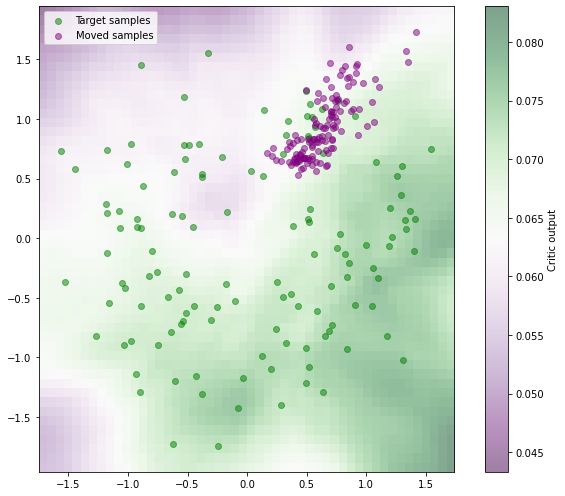

In [15]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=128,
    cost=InnerGW_opt(p, q),
    plotter=SimplePlotter(
        source_dim=p,
        target_dim=q,
        pdf_params=dict(
            source_lims=None,
            target_lims=None,
            n_points=500
        )
    # show_progress=False
    ),
    logger=wandb_logger,
    n_inner_iter=10,
    plot_interval=20,
    log_plot_interval=100,
)

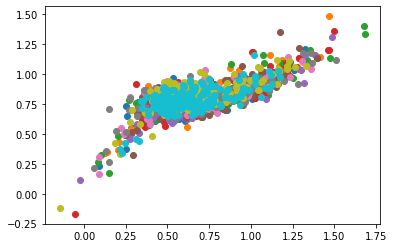

In [16]:
for cls in range(10):
    samples = source.sample_from_class((200,), 0)
    with torch.no_grad():
        moved_samples = solver.mover(samples.to(DEVICE))
    plot_samples(moved_samples.cpu())
plt.show()


<Figure size 432x288 with 0 Axes>

Output()

  0%|          | 0/500 [00:00<?, ?it/s]

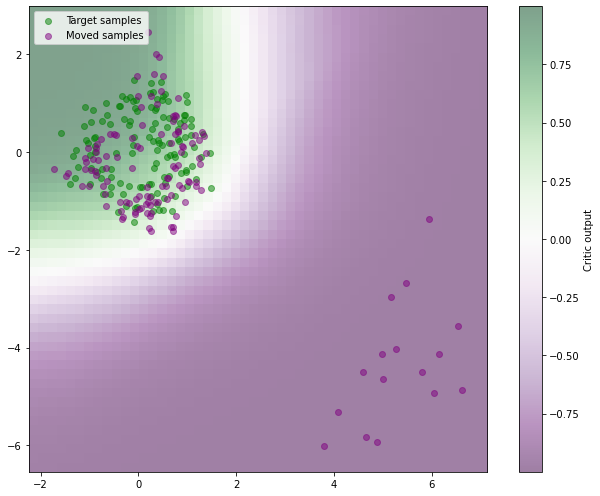

In [19]:
solver = run_experiment(
    source, target,
    n_iter=500,
    n_samples=128,
    cost=InnerGW_const(V.to(DEVICE)),
    plotter=SimplePlotter(
        source_dim=p,
        target_dim=q,
        pdf_params=dict(
            source_lims=None,
            target_lims=None,
            n_points=500
        )
    # show_progress=False
    ),
    logger=None,
    n_inner_iter=10,
    plot_interval=20,
    log_plot_interval=100,
)

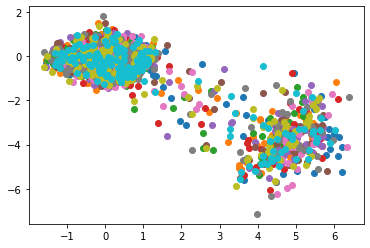

In [20]:
for cls in range(10):
    samples = source.sample_from_class((200,), 0)
    with torch.no_grad():
        moved_samples = solver.mover(samples.to(DEVICE))
    plot_samples(moved_samples.cpu())
plt.show()
